## import modules

In [2]:
#ktrain a lightweight wrapper library for the Keras deep learning library in Python
pip install ktrain

SyntaxError: invalid syntax (Temp/ipykernel_3232/3322269462.py, line 2)

In [1]:
import nltk
#nltk.download('vader_lexicon')

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### textblob for processing textual data

In [2]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

import ktrain
from ktrain import text

## Read from .csv files

In [4]:
pd1 = pd.read_csv("training.csv")
pd2 = pd.read_csv("validation.csv")
data = pd.concat([pd1,pd2])

In [6]:
data.shape

(7500, 3)

## Check if data is clean

In [7]:
#checking for missing values
print(pd1.isnull().sum())
print(pd2.isnull().sum())

ID        0
Tweet     0
Labels    0
dtype: int64
ID       0
Tweet    0
dtype: int64


In [8]:
#checking for duplicate rows
print(pd1.duplicated().sum())
print(pd2.duplicated().sum())

0
0


In [9]:
#Checking for outliers
print(data.describe())

                ID
count  7500.000000
mean   3750.500000
std    2165.207842
min       1.000000
25%    1875.750000
50%    3750.500000
75%    5625.250000
max    7500.000000


In [10]:
print(data.dtypes)

ID         int64
Tweet     object
Labels    object
dtype: object


In [11]:
#column labels 
print(data.keys())

Index(['ID', 'Tweet', 'Labels'], dtype='object')


### The text data (Corpus) that we will analyse is the column Tweet 

In [12]:
Corpus = data['Tweet']
Corpus

0       NO JOKE I WILL HOP ON A PLANE RN! (Well after ...
1       BanMediaHouse whose is responsible for spreadi...
2       Im waiting for someone to say to me that all t...
3       He is a liar. Proven day night. Time again. Li...
4       NEW: U.S. CoronaVirus death toll reaches 4,000...
                              ...                        
2495    Ease to re-search - Coronavirus started mainly...
2496    If J N U is postering in favour of corona clus...
2497    Gods word is powerful and I promise that if yo...
2498    My mom just made me drink boiled lemon, garlic...
2499    Children are calling the coronavirus the longe...
Name: Tweet, Length: 7500, dtype: object

### For the column Labels Labels - the labels of a tweet, indicated by the label index from 0 to 10 :
#### Optimistic (0), Thankful (1), Empathetic (2), Pessimistic (3), Anxious (4), Sad (5), Annoyed (6), Denial (7), 
#### Surprise (8), Official report (9), Joking (10).


## Data Cleaning

In [13]:
data['Tweet'] = data['Tweet'].str.lower()
data

,ID,Tweet,Labels
0,1,no joke i will hop on a plane rn! (well after ...,0 10
1,2,banmediahouse whose is responsible for spreadi...,6
2,3,im waiting for someone to say to me that all t...,3 4
3,4,he is a liar. proven day night. time again. li...,6
4,5,"new: u.s. coronavirus death toll reaches 4,000...",8
...,...,...,...
2495,7496,ease to re-search - coronavirus started mainly...,NaN
2496,7497,if j n u is postering in favour of corona clus...,NaN
2497,7498,gods word is powerful and i promise that if yo...,NaN
2498,7499,"my mom just made me drink boiled lemon, garlic...",NaN


In [14]:
!pip install nltk
nltk.download('stopwords')
nltk.download('punkt')

^C


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))
filtered_corpus = []
for doc in Corpus:
    words = word_tokenize(doc)
    words = [w for w in words if w not in stop_words]
    filtered_corpus.append(" ".join(words))

In [16]:
#Defining functions for Cleaning and Normalization of Data
import re
import string
def replace_url(string): # cleaning of URL
    text = re.sub(r'http\S+', 'LINK', string)
    return text


def replace_email(text):#Cleaning of Email related text
    line = re.sub(r'[\w\.-]+@[\w\.-]+','MAIL',str(text))
    return "".join(line)

In [17]:
def remove_duplicates(text):
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\1', text)
    return text

In [18]:
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [19]:
data["Tweet"] = data['Tweet'].apply(remove_punctuations)

In [21]:
data.shape

(7500, 3)

In [22]:
Labels = data['Labels']

In [23]:
Labels

0       0 10
1          6
2        3 4
3          6
4          8
        ... 
2495     NaN
2496     NaN
2497     NaN
2498     NaN
2499     NaN
Name: Labels, Length: 7500, dtype: object

# Word Embedding 

### Word Embedding is a technique used in natural language processing to represent words in a numerical format, called word vectors. 
### The goal of word embedding is to capture the meaning of words in a way that is useful for downstream natural language processing tasks, in our case sentiment analysis

In [24]:
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,Dense,Conv1D,Flatten,LSTM,GlobalMaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE

In [25]:
embed_num_dims = 50
max_seq_len = 1000

In [26]:
Corpus[0]
print(len(Corpus))

7500


In [27]:
dict = data['Labels']

In [29]:
sentences = data['Tweet']
sentences
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(sentences)
sequence = tokenizer.texts_to_sequences(sentences)

In [30]:
index_of_words = tokenizer.word_index
index_of_words
print(len(index_of_words))

12784


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
padded_seq = pad_sequences(sequence , maxlen = max_seq_len )
padded_seq

array([[   0,    0,    0, ...,  106,    8,  232],
       [   0,    0,    0, ...,  109,    3,  379],
       [   0,    0,    0, ...,   16,   22,   43],
       ...,
       [   0,    0,    0, ...,   48,  737,    8],
       [   0,    0,    0, ...,    2,   19, 1043],
       [   0,    0,    0, ..., 1537,   64,  260]])

In [33]:
#!pip install sklearn.cross_validation
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(padded_seq,dict,train_size = 0.7)

In [34]:
Y_train.head()

1253      4 10
3632    4 6 10
694       6 10
2738         2
695         10
Name: Labels, dtype: object

In [35]:
#pretrained Glove Word Embedding weights
import codecs
f = codecs.open('glove.6B.50d.txt', encoding='utf-8')
#f = open('glove.6B.50d.txt',encoding="utf8")
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [36]:
embedd_index['happy']

array([ 0.092086,  0.2571  , -0.58693 , -0.37029 ,  1.0828  , -0.55466 ,
       -0.78142 ,  0.58696 , -0.58714 ,  0.46318 , -0.11267 ,  0.2606  ,
       -0.26928 , -0.072466,  1.247   ,  0.30571 ,  0.56731 ,  0.30509 ,
       -0.050312, -0.64443 , -0.54513 ,  0.86429 ,  0.20914 ,  0.56334 ,
        1.1228  , -1.0516  , -0.78105 ,  0.29656 ,  0.7261  , -0.61392 ,
        2.4225  ,  1.0142  , -0.17753 ,  0.4147  , -0.12966 , -0.47064 ,
        0.3807  ,  0.16309 , -0.323   , -0.77899 , -0.42473 , -0.30826 ,
       -0.42242 ,  0.055069,  0.38267 ,  0.037415, -0.4302  , -0.39442 ,
        0.10511 ,  0.87286 ])

In [37]:
embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)

In [38]:
embedding_matrix.shape

(12785, 50)

## Sentiment Analysis with different tools

### TextBlob Sentiment Analysis

##### TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural 
##### language processing (NLP) tasks such as noun phrase extraction, sentiment analysis, classification, translation, and more.

In [39]:
data_TextBlob = data.copy()

In [40]:
def textblob_analysis(news_headline):
  analysis = TextBlob(news_headline)
  return analysis.sentiment.polarity

In [42]:
# Sentiment 'polarity' calculation for tweets
data_TextBlob['Compound'] = data_TextBlob['Tweet'].apply(lambda tweet: textblob_analysis(tweet))

In [43]:
data_TextBlob.head()

,ID,Tweet,Labels,Compound
0,1,no joke i will hop on a plane rn well after co...,0 10,0.800000
1,2,banmediahouse whose is responsible for spreadi...,6,-0.150000
2,3,im waiting for someone to say to me that all t...,3 4,0.000000
3,4,he is a liar proven day night time again lies ...,6,0.000000
4,5,new us coronavirus death toll reaches 4000 aft...,8,0.124242


In [44]:
# Label the tweets by the 'Compound' - by Sentiment Polarity values
# ( In TextBlob the scale moves between -1 and 1 )
def sentiment_declareation(sentiment_value):
  if sentiment_value == 0:
      return 'neutral'
  elif 0 < sentiment_value <= 0.3:
      return 'weakly_positive'
  elif 0.3 < sentiment_value <= 0.6:
      return 'positive'
  elif 0.6 < sentiment_value <= 1:
      return 'strongly_positive'
  elif -0.3 < sentiment_value <= 0:
      return 'weakly_negative'
  elif -0.6 < sentiment_value <= -0.3:
      return 'negative'
  elif -1 < sentiment_value <= -0.6:
      return 'strongly_negative'

In [45]:
# Sentiment labels for tweets after the 'Compound'
data_TextBlob['Sentiment'] = data_TextBlob['Compound'].apply(lambda value: sentiment_declareation(value))

# Set the Sentiment analysis tool name
data_TextBlob['Tool'] = 'TextBlob'

In [46]:
data_TextBlob.head()

,ID,Tweet,Labels,Compound,Sentiment,Tool
0,1,no joke i will hop on a plane rn well after co...,0 10,0.800000,strongly_positive,TextBlob
1,2,banmediahouse whose is responsible for spreadi...,6,-0.150000,weakly_negative,TextBlob
2,3,im waiting for someone to say to me that all t...,3 4,0.000000,neutral,TextBlob
3,4,he is a liar proven day night time again lies ...,6,0.000000,neutral,TextBlob
4,5,new us coronavirus death toll reaches 4000 aft...,8,0.124242,weakly_positive,TextBlob


In [47]:
# Sentiment informations with TextBlob
data_TextBlob['Sentiment']
values = data_TextBlob['Sentiment'].value_counts()
values

neutral              2627
weakly_positive      1901
weakly_negative      1185
positive              826
negative              525
strongly_positive     215
strongly_negative     189
Name: Sentiment, dtype: int64

In [48]:
# Return with a Dictionary with the selected dataframe sentiment labels count
# Note: The None sentiment labels also goes to the neutral section
def tool_sentiment_results(dataframe_sentiment_column):
  sentiment_result = {'neutral': 0, 
                      'strongly_negative': 0,  
                      'negative': 0,
                      'weakly_negative': 0,
                      'weakly_positive': 0,
                      'positive': 0,
                      'strongly_positive': 0 }

  for value in dataframe_sentiment_column:
    if value in sentiment_result:
      if value == 'strongly_negative':
        sentiment_result['strongly_negative'] += 1
      elif value == 'negative':
        sentiment_result['negative'] += 1
      elif value == 'weakly_negative':
        sentiment_result['weakly_negative'] += 1
      elif value == 'neutral':
        sentiment_result['neutral'] += 1
      elif value == 'weakly_positive':
        sentiment_result['weakly_positive'] += 1
      elif value == 'positive':
        sentiment_result['positive'] += 1
      elif value == 'strongly_positive':
        sentiment_result['strongly_positive'] += 1

  # Add the None values to the neutral as well
  sentiment_result['neutral'] += dataframe_sentiment_column.isna().sum()

  return sentiment_result

In [49]:
# Calculate the percentage of the different sentiment categories/labels ( - for example 30% weakly_positive with this tool )
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [50]:
# Visualize the sentiment percentages on a chart 
def visualization(positive, wpositive, spositive, negative, wnegative, snegative, neutral, keyword, limit, tool):
    labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]',
              'Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
              'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]',
              'Strongly Negative [' + str(snegative) + '%]']
    sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
    colors = ['yellowgreen', 'lightgreen', 'darkgreen', 'blue', 'red', 'gold', 'darkred']
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.title('How people are reacting on ' + keyword + ' by analyzing ' + str(limit) + ' Tweets with ' + tool)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [51]:
# Visualize the sentiment percentages of the selected tool and keyword information using the sentiment labels 
#from the tools dataframe
def sentiment_result_label_category_counts_visualisazion(dataframe, tool_name, keyword):
  datraframe_size = len(dataframe)
  dataframe_sentiment_labels_result = tool_sentiment_results(dataframe_sentiment_column=dataframe['Sentiment'])

  pos_percent       = percentage(part=dataframe_sentiment_labels_result['positive'], whole=datraframe_size)
  wpositive_percent = percentage(part=dataframe_sentiment_labels_result['weakly_positive'], whole=datraframe_size)
  spositive_percent = percentage(part=dataframe_sentiment_labels_result['strongly_positive'], whole=datraframe_size)
  negative_percent  = percentage(part=dataframe_sentiment_labels_result['negative'], whole=datraframe_size)
  wnegative_percent = percentage(part=dataframe_sentiment_labels_result['weakly_negative'], whole=datraframe_size)
  snegative_percent = percentage(part=dataframe_sentiment_labels_result['strongly_negative'], whole=datraframe_size)
  neutral_percent   = percentage(part=dataframe_sentiment_labels_result['neutral'], whole=datraframe_size)

  visualization(positive=pos_percent, wpositive=wpositive_percent, spositive=spositive_percent, negative=negative_percent, 
                wnegative=wnegative_percent, snegative=snegative_percent, neutral=neutral_percent, keyword=keyword, 
                limit=datraframe_size, tool=tool_name)


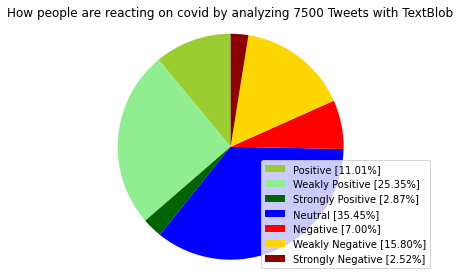

In [52]:
sentiment_result_label_category_counts_visualisazion(dataframe=data_TextBlob, tool_name='TextBlob', keyword='covid')

### NLTK Sentiment Analysis

In [53]:
import nltk

In [54]:
data_NLTK = data.copy()

In [56]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [57]:
# Test and tran datasets using the tensorflow datasets possibility
#dataSet, info = data
train_dataSet, test_dataSet = pd1, pd2
#encoder = info.features['Tweet'].encoder

In [58]:
sia=SentimentIntensityAnalyzer()

# Sentiment 'polarity' calculation for tweets
data_NLTK['Compound'] = data_NLTK['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet)['compound'])

In [59]:
# Label the tweets by the 'Compound' - by Sentiment Polarity values
# ( In NLTK the scale moves between -1 and 1 )
def sentiment_declareation(sentiment_value):
  if sentiment_value == 0:
      return 'neutral'
  elif 0 < sentiment_value <= 0.3:
      return 'weakly_positive'
  elif 0.3 < sentiment_value <= 0.6:
      return 'positive'
  elif 0.6 < sentiment_value <= 1:
      return 'strongly_positive'
  elif -0.3 < sentiment_value <= 0:
      return 'weakly_negative'
  elif -0.6 < sentiment_value <= -0.3:
      return 'negative'
  elif -1 < sentiment_value <= -0.6:
      return 'strongly_negative'

In [60]:
# Sentiment labels for tweets after the 'Compound'
data_NLTK['Sentiment'] = data_NLTK['Compound'].apply(lambda value: sentiment_declareation(value))

# Set the Sentiment analysis tool name
data_NLTK['Tool'] = 'NLTK'

In [61]:
data_NLTK.head()

,ID,Tweet,Labels,Compound,Sentiment,Tool
0,1,no joke i will hop on a plane rn well after co...,0 10,0.5994,positive,NLTK
1,2,banmediahouse whose is responsible for spreadi...,6,-0.2023,weakly_negative,NLTK
2,3,im waiting for someone to say to me that all t...,3 4,-0.2500,weakly_negative,NLTK
3,4,he is a liar proven day night time again lies ...,6,-0.5859,negative,NLTK
4,5,new us coronavirus death toll reaches 4000 aft...,8,-0.5719,negative,NLTK


In [74]:
# Sentiment informations with NLTK - vader lexicon
values = data_NLTK['Sentiment'].value_counts()
values

neutral              1414
negative             1331
positive             1229
strongly_negative    1094
weakly_negative       930
weakly_positive       798
strongly_positive     704
Name: Sentiment, dtype: int64

In [75]:
class_names = list(values.keys())
class_names

['neutral',
 'negative',
 'positive',
 'strongly_negative',
 'weakly_negative',
 'weakly_positive',
 'strongly_positive']

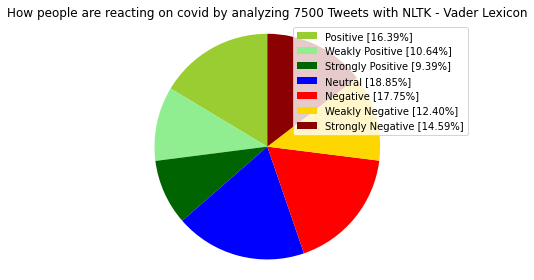

In [62]:
sentiment_result_label_category_counts_visualisazion(dataframe=data_NLTK, tool_name='NLTK - Vader Lexicon', keyword='covid')